In [1]:
import gymnasium as gym
import numpy as np
import matplotlib
import datetime
import requests
import pandas as pd
import time
import pygame
from pyproj import Transformer
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, Model
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

time_per_step = 1

In [2]:
class Weather:
    def __init__(self, date, lat, long, length, legs=None):
        """
        init function for Weather class

        :param date: the day that the trip is expected to start
        :param lat: the latitude of the location
        :param long: the longitude of the location
        :param length: the total length of the trip
        :param legs: an input for the legs of the journey
        """
        self.url = "https://api.tomorrow.io/v4/timelines"
        self.date = date
        self.lat = lat
        self.long = long
        self.length = length

        if legs is not None: # CHANGE SO THAT ROUTE API CALCS ARE PERFORMED IN WEATHER CLASS
            trail_data = {
                "name": "Your Trail Name",
                "polyline": legs,
                "tags": ["Toronto", "Bike"]
            }

    def get_weather_data(self, minutes_elapsed):
        """
        Get weather data for a given hour in the future.
    
        :param hour: Hour offset from now (e.g. 3 = 3 hours ahead)
        :return: Score based on weather conditions
        """
        hour = minutes_elapsed // 60
        minutes_elapsed = minutes_elapsed % 60
        start_time = date + datetime.timedelta(days=hour // 24)
        start_time = start_time.replace(hour=hour % 24, minute=minutes_elapsed, second=0, microsecond=0).isoformat() + "Z"
        
        params = {
            "location": f"{self.lat},{self.long}",
            "fields": [
                "temperature", "precipitationIntensity", "windSpeed",
                "humidity", "cloudCover", "dewPoint", "visibility", "weatherCode"
            ],
            "units": "metric",
            "startTime": start_time,
            "apikey": "YKleCJivm43lzWG54PyqHgKYdeV8YueX"  # or use API_KEY if global
        }
    
        response = requests.get(self.url, params=params)
        response.raise_for_status()
        data = response.json()
    
        return self.score_hour(data["data"]["timelines"][0]["values"])
    
    def score_hour(self, v):
        """
        a function that calculates the score of the weather. do not leak plz, very top secret
        :param v: two twos my word fam, idk why its called v. regardless, its like the weather json that tomorrow.io
        feeds me
        :return: the weather score obv
        """
        score = 0.0
        v["temperature"] = float(v["temperature"])
        v["precipitationIntensity"] = float(v["precipitationIntensity"])
        v["windSpeed"] = float(v["windSpeed"])
        v["humidity"] = float(v["humidity"])
        v["cloudCover"] = float(v["cloudCover"])
        v["dewPoint"] = float(v["dewPoint"])
        v["visibility"] = float(v["visibility"])
        v["weatherCode"] = int(v["weatherCode"])

        score += max(0, 10 - abs(v["temperature"] - 20) * 0.5)

        score -= min(10, v["precipitationIntensity"] * 10)

        score -= min(5, v["windSpeed"] * 0.5)

        if v["humidity"] < 40:
            score -= (40 - v["humidity"]) * 0.1
        elif v["humidity"] > 60:
            score -= (v["humidity"] - 60) * 0.1

        score += max(0, 2 - abs(v["cloudCover"] - 50) / 25)

        diff = abs(v["temperature"] - v["dewPoint"])

        score += min(2, v["visibility"] / 10)

        clear = {1000, 1100, 1101}
        rain = {4000, 4200, 4210, 4201}
        snow = {5000, 5100, 5101}
        if v["weatherCode"] in clear:
            score += 2
        elif v["weatherCode"] in rain.union(snow):
            score -= 5

        return score

    def score_each_hour(self):
        """
        Deprecated function that will be deprecated when we buy the Tomorrow.io enterprise plan
        :return: the weather score per hour
        """
        final = []
        print(self.length / 24)
        for i in range(1): # int(self.length / 24)
            # Example: use today's date at midnight UTC
            start_time = datetime.datetime.now() + datetime.timedelta(days=i)
            start_time = start_time.replace(hour=0, minute=0, second=0, microsecond=0).isoformat() + "Z"
            params = {
                "location": f"{self.lat},{self.long}",
                "fields": [
                    "temperature", "precipitationIntensity", "windSpeed",
                    "humidity", "cloudCover", "dewPoint", "visibility", "weatherCode"
                ],
                "timesteps": "1h",
                "units": "metric",
                "startTime": start_time,
                "apikey": API_KEY
            }
            while True:
                try:
                    print(params)
                    response = requests.get(self.url, params=params)
                    if "code" in response:
                        raise Exception
                    else:
                        print("FINISHED")
                        break
                except requests.RequestException as e:
                    time.sleep(1)
            data = response.json()
            print(data)
            hourly_score = []
            for i in range(int(self.length % 24)):
                if "code" in data and data["code"] == 429001:
                    print("rate_limit")
                    break  # rate limit

                if "data" not in data:
                    hourly_score.append({})
                    continue

                v = data["data"]["timelines"][0]["intervals"][i]["values"]
                print(v)
                hourly_score.append(self.score_hour(v))
            final += hourly_score
        print(final)
        return final

    def __repr__(self):
        """
        PyCharm gave me this. idk why it uses the __ __ thingy. also, did you know that ethan is stinky? lol im so
        mature
        :return:
        """
        return f"Weather(date={self.date}, temperature={self.temperature}, precipitation={self.precipitation}, wind_speed={self.wind_speed})"

    def find_sunrise(self):
        """
        Mans got a function to check when sunrise’s gonna pop off, y’know?
        :return: the hour that the sun will set in the 24 hour clock
        """
        params = {
            "location": f"{self.lat},{self.long}",
            "fields": "sunriseTime",
            "timesteps": "1d",
            "units": "metric",
            "apikey": API_KEY
        }
        response = requests.get(self.url, params=params)
        data = response.json()

        sunrise_time = data["data"]["timelines"][0]["intervals"][0]["values"]["sunriseTime"]

        colon_loc = sunrise_time.index(":")
        if int(sunrise_time[colon_loc + 1] + sunrise_time[colon_loc + 2]) <= 30:
            sunrise_time = int(sunrise_time[colon_loc - 1]) - 5
        else:
            sunrise_time = int(sunrise_time[colon_loc - 1]) - 4

        return sunrise_time % 24

    def find_sunset(self):
        """
        Returns the hour of sunset in 24-hour time (UTC).
        :return: Integer hour (0–23) when the sun will set.
        """
        params = {
            "location": f"{self.lat},{self.long}",
            "fields": ["sunsetTime"],
            "timesteps": "1d",
            "units": "metric",
            "apikey": self.api_key
        }
    
        response = requests.get(self.url, params=params)
        response.raise_for_status()
        data = response.json()
    
        try:
            sunset_str = data["data"]["timelines"][0]["intervals"][0]["values"]["sunsetTime"]
            sunset_dt = datetime.datetime.fromisoformat(sunset_str.replace("Z", "+00:00"))
            return sunset_dt.hour
        except (KeyError, IndexError, ValueError) as e:
            print("Failed to retrieve or parse sunset time:", e)
            return None

In [3]:
def hunger_formula(time_spent):
    """
    https://www.desmos.com/calculator/uw9wtuuriz
    """
    k = 0.2
    time_spent = time_spent // time_per_step
    return 100/(1+np.e**(-k * (time_spent - 45))) - 100/(1+np.e**(-k * (time_spent - time_per_step - 45)))

def fatigue_formula(time_spent):
    """
    https://www.desmos.com/calculator/uw9wtuuriz
    """
    k = 0.03
    time_spent = time_spent // time_per_step
    return 100/(1+np.e**(-k * (time_spent - 240))) - 100/(1+np.e**(-k * (time_spent - time_per_step - 240)))

def fetch_weather_for_location(lat, lon, start_dt, end_dt, step_minutes, api_key, url):
    """
    Fetches a time series of weather data for a single location.

    :param lat: Latitude of the location.
    :param lon: Longitude of the location.
    :param start_dt: datetime.datetime start of the period.
    :param end_dt: datetime.datetime end of the period.
    :param step_minutes: Interval between samples in minutes.
    :param api_key: Your weather API key.
    :param url: Weather API endpoint URL.
    :return: List of dictionaries with time and weather values.
    """
    params = {
        "location": f"{lat},{lon}",
        "fields": ["temperature", "precipitationIntensity", "windSpeed",
                   "humidity", "cloudCover", "dewPoint", "visibility", "weatherCode"],
        "timesteps": f"{step_minutes}m",
        "startTime": start_dt.replace(microsecond=0).isoformat() + "Z",
        "endTime": end_dt.replace(microsecond=0).isoformat() + "Z",
        "apikey": api_key
    }
    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()
    intervals = data["data"]["timelines"][0]["intervals"]
    result = []
    for interval in intervals:
        values = interval["values"]
        result.append({
            "time": interval["startTime"],
            "lat": lat,
            "lon": lon,
            "temperature": values.get("temperature"),
            "precipitationIntensity": values.get("precipitationIntensity"),
            "windSpeed": values.get("windSpeed"),
            "humidity": values.get("humidity"),
            "cloudCover": values.get("cloudCover"),
            "dewPoint": values.get("dewPoint"),
            "visibility": values.get("visibility"),
            "weatherCode": values.get("weatherCode")
        })
    return result

def cache_weather_to_csv(tile_coords, start_dt, total_minutes, step_minutes,
                         api_key, url, output_csv="weather_cache.csv"):
    """
    Fetches weather for all tile_coords over a time window and writes to CSV.

    :param tile_coords: List of (lat, lon) tuples.
    :param start_dt: datetime.datetime start of the period.
    :param total_minutes: Total duration in minutes.
    :param step_minutes: Sampling interval in minutes.
    :param api_key: Your weather API key.
    :param url: API endpoint URL.
    :param output_csv: Output CSV filename.
    """
    end_dt = start_dt + datetime.timedelta(minutes=total_minutes)
    all_records = []
    print(tile_coords[0])
    transformer = Transformer.from_crs("EPSG:32536", "EPSG:4326", always_xy=True)
    tile_coords = map(lambda x: transformer.transform(x[0], x[1]), tile_coords)
    for lat, lon in tile_coords:
        while True:
            try:
                records = fetch_weather_for_location(lat, lon, start_dt, end_dt,
                                                 step_minutes, api_key, url)
                break
            except requests.exceptions.HTTPError as err:
                print("too many requests!")
                time.sleep(1)
        all_records.extend(records)
    df = pd.DataFrame(all_records)
    df.to_csv(output_csv, index=False)
    print(f"Saved {len(df)} records to {output_csv}")

# Example usage:
# tile_coords = [(45.4215, -75.6972), (46.0, -75.0), ...]  # list of lat/lon pairs
# start_dt = datetime.datetime.today()
# cache_weather_to_csv(
#     tile_coords=tile_coords,
#     start_dt=start_dt,
#     total_minutes=2000 * 5,  # total simulated minutes (2000 tiles * 5min/tile)
#     step_minutes=5,
#     api_key="YOUR_API_KEY",
#     url="https://api.tomorrow.io/v4/timelines"
# )
x = [407.824000,
415.430000,
422.404000,
424.343000,
427.964000,
432.360000,
435.720000,
439.831000,
433.041000,
428.898000,
429.874000,
415.827000,
415.172000,
426.110000,
421.778000,
441.403000,
450.665000,
457.463000,
459.623000,
463.176000,
461.311000,
460.205000,
457.479000,
453.592000,
443.880000,
458.189000,
461.424000,
463.249000,
454.262000,
452.399000,
443.234000,
444.980000,
436.737000,
441.904000,
442.663000,
426.324000,
447.518000,
422.789000,
432.130000,
422.061000,
426.197000,
428.290000,
414.659000,
416.617000,
406.974000,
403.599000,
413.518000,
417.049000,
421.853000,
434.480000,
431.075000,
429.101000,
434.046000,
439.786000,
436.005000,
427.979000,
434.553000,
415.248000,
422.074000,
413.536000,
433.295000,
439.165000,
440.715000,
441.306000,
442.117000,
446.678000,
447.078000,
446.251000,
442.970000,
441.298000,
431.745000,
439.642000,
434.185000,
430.544000,
429.025000,
441.301000,
455.995000,
464.050000,
465.210000,
465.310000,
464.170000,
466.506000,
461.330000,
458.663000,
461.381000,
461.033000,
467.724000,
467.724000,
454.786000,
446.497000,
436.700000,
444.029000,
451.490000,
455.752000,
455.847000,
454.295000,
447.915000,
450.432000,
457.359000,
448.498000,
446.403000,
442.545000,
454.752000,
444.132000,
449.491000,
457.850000,
458.244000,
460.386000,
472.368000,
474.606000,
475.539000,
469.992000,
470.162000,
482.235000,
485.870000,
491.179000,
498.497000,
484.277000,
493.440000,
482.978000,
482.759000,
477.062000,
477.210000,
473.492000,
476.991000,
475.044000,
477.677000,
478.727000,
470.328000,
468.563000,
461.593000,
462.519000,
468.675000,
475.413000,
466.400000,
475.840000,
481.946000,
476.694000,
469.296000,
462.964000,
463.240000,
467.465000,
479.365000,
467.240000,
468.348000,
468.770000,
477.647000,
480.052000,
489.054000,
488.955000,
498.414000,
496.780000,
499.863000,
502.430000,
499.641000,
491.779000,
489.150000,
491.573000,
482.324000,
476.735000,
481.256000,
485.527000,
491.520000,
485.694000,
493.921000,
512.641000,
523.091000,
523.884000,
522.545000,
514.917000,
517.052000,
515.331000,
516.618000,
502.885000,
492.744000,
485.119000,
475.791000,
464.971000,
453.892000,
452.544000,
456.122000,
451.757000,
452.312000,
456.707000,
472.190000,
468.149000,
466.217000,
470.285000,
476.327000,
466.373000,
473.254000,
465.201000,
465.270000,
450.744000,
423.319000,
434.056000,
445.880000,
442.793000,
446.717000,
462.974000,
451.731000,
465.215000,
466.053000,
467.444000,
470.000000,
472.009000,
463.619000,
462.249000,
454.640000,
454.081000,
451.339000,
454.270000,
442.196000,
450.033000,
451.067000,
454.549000,
456.708000,
459.612000,
465.255000,
462.705000,
456.814000,
460.447000,
462.174000,
457.300000,
453.312000,
453.164000,
445.250000,
436.814000,
446.735000,
447.030000,
444.757000,
453.136000,
466.146000,
459.906000,
459.355000,
465.579000,
461.624000,
463.555000,
463.926000,
462.728000,
460.018000,
454.379000,
468.841000,
460.836000,
458.717000,
452.608000,
432.727000,
427.287000,
427.907000,
428.211000,
418.300000,
427.383000,
433.329000,
427.624000,
436.056000,
440.234000,
439.499000,
433.157000,
433.157000,
446.189000,
441.744000,
440.098000,
426.159000,
433.820000,
447.096000,
449.607000,
437.616000,
442.810000,
441.621000,
436.913000,
444.424000,
445.401000,
450.557000,
429.502000,
429.502000,
444.977000,
437.937000,
457.334000,
458.878000,
460.457000,
453.464000,
455.643000,
449.737000,
450.598000,
445.493000,
447.327000,
435.601000,
434.509000,
428.213000,
432.127000,
440.661000,
445.549000,
427.216000,
436.002000,
441.069000,
437.092000,
440.740000,
435.885000,
441.190000,
447.691000,
438.129000,
448.292000,
432.550000,
435.137000,
432.133000,
436.785000,
456.127000,
453.825000,
460.583000,
462.311000,
453.453000,
464.567000,
465.817000,
463.588000,
467.702000,
463.342000,
462.741000,
453.080000,
457.323000,
453.714000,
459.299000,
455.587000,
451.640000,
455.501000,
452.838000,
458.753000,
446.381000,
461.640000,
459.551000,
453.881000,
454.847000,
445.910000,
444.124000,
455.778000,
455.561000,
459.517000,
457.066000,
445.060000,
447.654000,
445.246000,
446.469000,
429.147000,
429.147000,
446.469000,
445.246000,
449.363000,
445.908000,
443.490000,
442.615000,
432.180000,
432.180000,
442.615000,
439.174000,
457.257000,
450.852000,
454.458000,
457.682000,
460.535000,
448.480000,
453.629000,
454.616000,
455.086000,
452.394000,
456.904000,
460.029000,
458.672000,
462.416000,
463.978000,
468.536000,
465.937000,
470.393000,
464.757000,
466.047000,
457.010000,
459.818000,
457.479000,
451.294000,
457.197000,
455.801000,
459.710000,
468.961000,
462.716000,
469.838000,
447.169000,
446.069000,
447.964000,
468.334000,
474.464000,
479.590000,
475.596000,
479.791000,
474.157000,
470.231000,
469.866000,
467.972000,
467.737000,
466.910000,
469.164000,
466.817000,
471.788000,
472.124000,
474.403000,
478.352000,
465.760000,
474.316000,
476.905000,
474.835000,
474.536000,
462.935000,
473.069000,
471.533000,
466.544000,
462.061000,
461.054000,
458.472000,
454.069000,
463.469000,
459.179000,
456.079000,
456.601000,
456.872000,
453.190000,
458.064000,
449.568000,
457.424000,
459.132000,
466.413000,
465.532000,
464.926000,
465.351000,
457.692000,
461.357000,
465.777000,
473.352000,
463.640000,
474.265000,
470.825000,
462.929000,
459.935000,
457.391000,
462.942000,
452.577000,
450.401000,
439.960000,
447.765000,
443.375000,
436.978000,
438.570000,
445.538000,
451.293000,
451.796000,
450.842000,
445.790000,
455.555000,
453.728000,
443.130000,
441.940000,
452.433000,
456.263000,
451.851000,
456.812000,
453.791000,
452.581000,
457.648000,
459.147000,
462.618000,
465.444000,
465.978000,
464.501000,
467.251000,
460.480000,
463.391000,
452.374000,
459.791000,
449.094000,
449.385000,
447.215000,
448.339000,
451.060000,
456.725000,
445.957000,
440.204000,
425.390000,
440.454000,
450.908000,
455.746000,
458.757000,
457.972000,
455.079000,
449.471000,
450.937000,
468.733000,
463.392000,
460.655000,
465.014000,
479.634000,
493.901000,
501.109000,
508.548000,
508.409000,
512.718000,
501.812000,
516.941000,
515.498000,
501.050000,
506.460000,
506.188000,
508.303000,
505.968000,
503.347000,
500.285000,
493.526000,
487.113000,
477.414000,
475.297000,
480.910000,
492.966000,
491.619000,
489.449000,
482.750000,
488.829000,
491.885000,
499.926000,
498.342000,
488.058000,
481.209000,
484.087000,
484.237000,
478.170000,
464.735000,
466.651000,
486.412000,
484.997000,
492.320000,
489.248000,
477.094000,
486.130000,
498.500000,
496.004000,
498.632000,
489.034000,
483.005000,
483.152000,
477.781000,
459.412000,
464.250000,
467.225000,
460.960000,
453.690000,
446.002000,
447.311000,
442.091000,
448.083000,
448.334000,
450.062000,
435.741000,
434.235000,
452.816000,
464.314000,
457.051000,
465.084000,
455.879000,
473.193000,
475.358000,
470.689000,
470.689000,
475.358000,
473.193000,
465.056000,
470.424000,
474.522000,
466.591000,
468.531000,
467.164000,
460.980000,
465.874000,
461.115000,
461.115000,
465.874000,
469.355000,
458.929000,
457.085000,
457.085000,
458.929000,
469.355000,
460.980000,
467.164000,
468.531000,
466.591000,
474.522000,
470.424000,
465.056000,
473.193000,
475.358000,
470.689000,
469.992000,
470.162000,
482.235000,
485.870000,
491.179000,
498.497000,
484.277000,
493.440000,
482.978000,
482.759000,
477.062000,
472.478000,
458.051000,
459.622000,
460.306000,
451.369000,
451.369000,
460.306000,
459.622000,
458.051000,
472.478000,
477.062000,
482.759000,
482.978000,
493.440000,
484.277000,
498.497000,
491.179000,
485.870000,
482.235000,
470.162000,
469.992000,
475.539000,
474.606000,
472.368000,
460.386000,
458.244000,
457.850000,
449.491000,
444.132000,
454.752000,
442.545000,
446.403000,
448.498000,
457.359000,
450.432000,
447.915000,
454.295000,
450.934000,
450.934000,
454.295000,
454.295000,
455.847000,
455.752000,
451.490000,
444.029000,
436.700000,
446.497000,
454.786000,
454.511000,
450.378000,
446.051000,
446.051000,
450.378000,
448.044000,
448.044000,
454.511000,
444.297000,
452.035000,
448.574000,
448.574000,
448.574000,
448.574000,
452.035000,
444.297000,
454.786000,
454.786000,
467.724000,
460.406000,
461.166000,
464.904000,
459.184000,
456.989000,
451.434000,
452.338000,
436.360000,
436.360000,
447.428000,
459.123000,
452.338000,
447.428000,
447.428000,
447.428000,
453.836000,
453.836000,
459.123000,
451.434000,
456.989000,
459.184000,
464.904000,
461.166000,
460.406000,
467.724000,
461.033000,
461.381000,
458.663000,
461.330000,
466.506000,
464.170000,
465.310000,
465.210000,
464.050000,
459.845000,
458.162000,
465.386000,
464.805000,
467.547000,
473.010000,
476.035000,
473.282000,
478.362000,
485.840000,
484.724000,
478.457000,
462.129000,
455.492000,
452.808000,
452.808000,
455.492000,
462.129000,
478.457000,
484.724000,
484.093000,
481.475000,
465.598000,
463.698000,
464.615000,
463.939000,
460.596000,
454.970000,
446.313000,
444.339000,
442.944000,
444.431000,
454.490000,
453.144000]
coordinates = [
(690222.6916955005,5044053.782302721),
(694442.7866072473,5046974.564000491),
(694437.6626989216,5046927.001905544),
(694448.7357072008,5046886.3148178505),
(694438.3467126315,5046838.932261487),
(694411.0311885483,5046802.485210374),
(694369.5343703189,5046775.705724017),
(694322.7776931088,5046763.263283028),
(694278.6192634295,5046745.741608668),
(694244.6082108642,5046709.6793803),
(694207.435977616,5046675.931411967),
(694174.8112811921,5046638.161672476),
(694153.9334950013,5046592.583843218),
(694148.6086057044,5046543.969063327),
(694170.3655550091,5046501.905225462),
(694175.6279114613,5046453.194553231),
(694150.2341738179,5046416.183269264),
(694119.484024771,5046377.190649005),
(694093.2941666226,5046334.672404752),
(694066.3140989734,5046292.572884889),
(694044.0009487369,5046247.506172758),
(694020.5771958614,5046208.357049251),
(693973.6458614503,5046207.164652987),
(693924.9197803198,5046209.745518389),
(693876.8579385978,5046195.259653298),
(693831.7790897759,5046175.740323218),
(693784.0668592539,5046170.305575644),
(693741.1402084435,5046153.115881912),
(693706.1933826763,5046123.115093307),
(693679.4527427355,5046083.129150454),
(693634.2347490268,5046065.658092178),
(693586.2613439206,5046059.939039217),
(693538.477129969,5046074.253220935),
(693494.5453212934,5046098.0764910905),
(693466.3223944061,5046126.274289833),
(693486.0443901615,5046170.081534644),
(693512.6737473803,5046211.077103873),
(693523.372642416,5046256.53924211),
(693498.3471364593,5046294.948746954),
(693455.2011368085,5046313.412694424),
(693407.4179922043,5046308.275991873),
(693362.006312986,5046287.918662079),
(693314.7438342584,5046272.919472829),
(693270.5663310454,5046249.252762115),
(693222.364049413,5046238.843232247),
(693172.3295125007,5046235.503931567),
(693121.9401946831,5046234.520123186),
(693072.0713570648,5046233.792807012),
(693053.752183465,5046202.315351781),
(693075.68277367,5046157.6493274),
(693100.6105832965,5046115.138762119),
(693105.3631992718,5046065.524842823),
(693095.5626884021,5046016.948674145),
(693068.6070217573,5045975.018329577),
(693045.3308677175,5045930.4883919805),
(693035.3102810233,5045881.813612637),
(693024.8800283831,5045833.405763771),
(693000.5781599357,5045790.8476034505),
(692974.8488645672,5045752.120331497),
(692954.8086227636,5045707.307184478),
(692936.509437256,5045661.552366963),
(692916.8088390992,5045616.538532585),
(692881.8806665675,5045582.659356139),
(692844.3862036958,5045550.344243887),
(692816.1342169328,5045509.561873244),
(692785.5375825538,5045470.247134959),
(692742.9409513184,5045461.399049654),
(692702.1169675259,5045489.578172862),
(692659.6980466327,5045514.072398326),
(692615.8456247828,5045520.29906513),
(692569.1776418557,5045531.901024777),
(692523.9395967168,5045551.131277972),
(692476.9198184715,5045539.7276183115),
(692439.7412370965,5045531.240826152),
(692423.2725284053,5045565.71046546),
(692388.5933291466,5045585.070511366),
(692351.2469341949,5045594.877614568),
(692306.150982659,5045573.950071328),
(692259.9524951502,5045556.536568368),
(692217.9366969666,5045530.608509527),
(692185.8063411014,5045492.372672711),
(692163.4769735773,5045447.428797783),
(692133.0389848863,5045408.955665259),
(692092.5806750547,5045379.682628354),
(692051.1963880993,5045351.450363951),
(692009.2854468343,5045328.852847633),
(691963.1164817883,5045311.427680579),
(691925.4794898648,5045278.503656599),
(691894.766719923,5045238.907680718),
(691865.1887675829,5045199.0556531595),
(691835.6503356212,5045163.295100362),
(691821.5060150925,5045125.034151105),
(691778.8886487216,5045121.212602799),
(691739.1315236102,5045091.465631609),
(691695.793397254,5045065.785679452),
(691655.2059094328,5045036.120269177),
(691608.9626577916,5045017.222838123),
(691564.7720648989,5044994.357290162),
(691538.1000482246,5044952.937770322),
(691519.3125288911,5044906.138484189),
(691502.1866008017,5044859.4450458065),
(691470.6992427915,5044820.6429820405),
(691436.0186752471,5044784.230098697),
(691408.8867190883,5044744.203240054),
(691389.7325725618,5044699.308331937),
(691364.445292889,5044655.923468885),
(691341.7058597252,5044611.218141794),
(691302.976647187,5044584.22547327),
(691255.9478075405,5044566.269154004),
(691206.8993505051,5044557.815044374),
(691157.3294051638,5044551.421719609),
(691111.136839142,5044532.303085399),
(691062.036073893,5044521.643504966),
(691012.0957742266,5044514.730224354),
(690962.4688507614,5044506.857558072),
(690925.4648185042,5044478.000168544),
(690899.7576741452,5044435.227308583),
(690858.8774472439,5044407.668905946),
(690813.4416258138,5044385.715362842),
(690769.8431554326,5044360.494518446),
(690729.1513401038,5044330.681002126),
(690688.7268140387,5044300.473536417),
(690649.2117096025,5044291.624010544),
(690611.8527117339,5044314.836584492),
(690562.1839314874,5044309.125737012),
(690514.0893791458,5044294.091863531),
(690466.7328581557,5044279.021709746),
(690416.6712282137,5044277.365008963),
(690373.7334531883,5044256.505574776),
(690344.718935509,5044216.787109077),
(690313.3377073569,5044180.149843209),
(690283.603195429,5044157.086055502),
(690262.3816460543,5044116.336702628),
(690238.5785175159,5044074.179619403),
(690233.6793836877,5044027.172749676),
(690233.4623489105,5043979.649191397),
(690221.6189691885,5043933.770930946),
(690250.8155970133,5043896.968794139),
(690297.6760431125,5043888.227176398),
(690345.9543098997,5043899.310555899),
(690393.0221186852,5043893.027994774),
(690438.1143826979,5043906.600104617),
(690480.8074213731,5043928.311358454),
(690529.5048316959,5043941.325716269),
(690577.107936387,5043962.744892999),
(690624.8075622674,5043984.5606400585),
(690670.3879670977,5044011.427398975),
(690718.6777836526,5044030.513685287),
(690509.382992071,5043917.788607927),
(690744.3051147768,5044000.617841616),
(693084.1661334224,5042920.34882453),
(693055.3474401432,5042956.427100792),
(693018.6912487831,5042981.1932587875),
(692974.8222768076,5042964.618752957),
(692930.177701531,5042969.740532401),
(692921.1003411316,5043007.664523648),
(692894.9850943866,5043047.2558285715),
(692857.4996113733,5043077.673972861),
(692820.7469457268,5043110.731386379),
(692787.0476895066,5043145.672520214),
(692765.5566965457,5043188.693425458),
(692752.3577404979,5043236.313192837),
(692729.3285295848,5043280.607165791),
(692718.1730801988,5043328.2160751475),
(692706.3965355615,5043376.611471247),
(692684.5592637244,5043418.909536273),
(692648.450875795,5043451.761357164),
(692611.3488731921,5043483.588239),
(692575.4214726755,5043518.077075323),
(692539.5304874388,5043553.238013867),
(692503.6952577071,5043588.458125081),
(692468.0811450657,5043623.897780554),
(692435.6877995146,5043661.325370164),
(692404.5226327707,5043698.522336107),
(692376.3538669553,5043735.831132744),
(692344.0042793502,5043769.531022356),
(692327.2811920312,5043814.4654235),
(692305.8507891836,5043859.85595584),
(692283.5148200314,5043904.590833751),
(692249.0631719157,5043938.779125247),
(692205.9609832284,5043964.3289507665),
(692162.4524414709,5043989.459605593),
(692118.9530722501,5044014.606577843),
(692075.2671940938,5044039.430242686),
(692031.5804494707,5044064.252405537),
(691987.8937048472,5044089.074568387),
(691944.2014889217,5044113.886840154),
(691898.9160441232,5044132.711526048),
(691853.065188283,5044133.148354351),
(691804.0765359586,5044139.754170385),
(691755.0636820185,5044139.384256276),
(691716.2916232812,5044155.084462166),
(691682.1577992912,5044185.016490575),
(691634.4137356795,5044191.559827162),
(691590.5249094373,5044172.032591538),
(691554.1876647077,5044188.017706805),
(691515.435740353,5044175.352639419),
(691477.5704213175,5044142.886455025),
(691432.077762543,5044122.828062302),
(691387.3983969056,5044126.332860432),
(691343.2905714294,5044143.037103221),
(691295.9931813943,5044151.780676053),
(691248.5996579952,5044152.345908445),
(691203.35925272,5044164.201681875),
(691160.2101497158,5044159.0910592815),
(691119.3589901818,5044168.817426097),
(691072.4709796015,5044158.806576486),
(691026.0415028447,5044141.035632192),
(690986.9298366989,5044118.130355207),
(690942.695623715,5044107.2723281905),
(690896.9747590706,5044102.912510954),
(690851.7242254552,5044086.084469392),
(690813.36264279,5044055.320484515),
(690768.9776103025,5044038.533152512),
(693055.9640374574,5042886.83191622),
(693018.8242603331,5042846.177961196),
(693010.8957943431,5042787.632499587),
(693127.122303711,5042765.97103462),
(693078.0630066093,5042740.830438066),
(693146.2448834388,5042791.533928127),
(693106.7578039127,5042830.481287819),
(693078.5171125246,5042870.481664736),
(695219.4193768235,5048789.311715176),
(695218.3579104234,5048837.706643168),
(695217.3200649898,5048884.577716354),
(695205.2579411676,5048928.099915731),
(695168.1445685668,5048920.857381349),
(695123.2144127222,5048903.711966097),
(695083.2526234721,5048921.283394911),
(695049.9637983069,5048951.938044937),
(695007.1447502591,5048966.811682733),
(694967.9170529939,5048990.836985852),
(694948.5254311962,5049031.791767348),
(694911.175775401,5049061.042300292),
(694871.4385387547,5049082.656035352),
(694825.7875493993,5049068.4944855245),
(694785.6920773037,5049041.736684735),
(694738.6347455253,5049028.482538777),
(694694.869244138,5049013.3392796405),
(694646.8081851093,5049008.741546393),
(694599.804186887,5048999.341678058),
(694566.5840710438,5049027.086554649),
(694535.0802841267,5049016.745576174),
(694491.4726644232,5049003.885218841),
(694444.3486952581,5049009.169022566),
(694397.1555784637,5049021.537196611),
(694350.8088891734,5049037.7557159765),
(694304.6343721186,5049038.660482951),
(694260.9957165157,5049046.967383979),
(694225.5294299993,5049038.79841252),
(694208.1729407893,5048993.124818424),
(694178.6243587441,5048976.958854036),
(694169.9101452341,5049021.537466392),
(694145.002162901,5049024.915867197),
(694102.138550817,5049018.040227179),
(694053.9995852215,5049019.4180138),
(694007.1492163497,5049010.582805224),
(693958.4277035069,5049002.313743604),
(693909.2285164007,5049004.206097641),
(693860.6136701234,5049005.549813849),
(693828.2675495548,5049036.839279933),
(693808.388432486,5049078.903067904),
(693775.4590530582,5049112.303680567),
(693746.0598454118,5049152.188894002),
(693719.8958064754,5049194.213522666),
(693715.1045204991,5049243.026224592),
(693731.0259923972,5049290.368476808),
(693742.6245338621,5049338.4397708755),
(693751.9430331802,5049387.582634817),
(693756.4325833491,5049436.011339729),
(693720.5424528962,5049459.9174775975),
(693676.0440844934,5049445.241048532),
(693653.0403574725,5049402.70541419),
(693626.0179437306,5049360.735026047),
(693607.6852931061,5049316.445991522),
(693571.9374325589,5049286.366843136),
(693553.0483234993,5049244.083970646),
(693528.148799342,5049200.809007424),
(693506.7789548298,5049155.52055713),
(693489.3333714656,5049108.618142182),
(693479.8068970905,5049059.25568088),
(693462.3148004313,5049015.5535364235),
(693422.4723578565,5049021.244589629),
(693396.403388897,5049062.110658521),
(693379.2723569268,5049107.942944555),
(693364.1588129873,5049154.588148994),
(693359.1806622428,5049203.984710734),
(693349.2705386617,5049252.170651257),
(693346.4808261376,5049301.906666824),
(693355.8266549392,5049350.604522093),
(693342.9378876004,5049395.8926039105),
(693332.6360030852,5049443.060222459),
(693306.6427898443,5049484.729014539),
(693279.2896356331,5049523.926500722),
(693279.5072883872,5049572.061259875),
(693250.9262810434,5049583.468543149),
(693218.4704661097,5049556.188499543),
(693170.4835054391,5049552.391214997),
(693122.0073855388,5049546.369198236),
(696214.0473615209,5047320.056402552),
(696190.5749802326,5047283.1183288405),
(696168.8746396132,5047244.073668217),
(696141.8881786837,5047205.269543388),
(696111.5421392225,5047167.9067680985),
(696085.2997678096,5047126.208726391),
(696049.7569742773,5047093.757223439),
(696018.9331617781,5047057.559140026),
(695986.1119368393,5047031.343170009),
(695960.6058574283,5046993.571832573),
(695965.1554628724,5046947.700142685),
(695985.5791083917,5046904.670561805),
(696004.4436257352,5046859.795059823),
(696010.576751598,5046812.745752272),
(696014.1060660275,5046764.092071215),
(696008.6092839751,5046718.07144766),
(696011.8136946885,5046669.987617887),
(696025.3173867343,5046624.149474402),
(696043.3536453701,5046579.611653134),
(696073.4034908166,5046545.32200638),
(696087.3019048063,5046502.002292883),
(696084.1178565447,5046455.843349537),
(696082.570031347,5046409.561883253),
(696071.2428466424,5046362.213544869),
(696073.2332697422,5046313.493561784),
(696079.0773664599,5046268.2023746325),
(696099.77359753,5046244.662556428),
(696146.4666212407,5046246.371099083),
(696194.5416524268,5046243.924335677),
(696216.9944063574,5046209.8950889325),
(696254.6406986265,5046184.224592195),
(696301.9169512596,5046189.502712227),
(696347.8781925854,5046175.50087389),
(696395.5004723043,5046160.674659637),
(696443.0207311398,5046147.59955474),
(696474.2730639311,5046110.495270249),
(696504.5242593471,5046071.766420761),
(696521.9722700709,5046028.759647325),
(696511.1742357867,5045980.443861197),
(696501.4706240426,5045932.250360784),
(696476.8970919192,5045889.223493076),
(696455.3654589312,5045844.506012531),
(696431.5954467631,5045801.437462694),
(696395.2069069146,5045769.183583644),
(696377.6824105169,5045723.368285095),
(696378.2794814117,5045674.959854218),
(696381.5559366043,5045627.423064806),
(696389.5920767592,5045579.138895259),
(696386.699456261,5045529.616705521),
(696369.1127290466,5045484.212808615),
(696351.1962979317,5045444.9140970465),
(696305.229357758,5045436.332695289),
(696257.4664285386,5045446.779877074),
(696211.512343748,5045462.677812708),
(696163.6824916946,5045456.806676696),
(696119.0917087788,5045436.680906911),
(696074.0061510105,5045420.761805206),
(696037.028903009,5045388.930086936),
(695994.6036790346,5045368.629756711),
(695982.1984715045,5045330.914495349),
(695949.2017499012,5045301.613397631),
(695914.7460604213,5045270.324160498),
(695882.4853405205,5045240.8532614205),
(695866.0253193757,5045199.059236703),
(695824.5868939029,5045186.929437729),
(695781.4414360909,5045182.542032942),
(695738.7533225154,5045182.137703549),
(695701.2656405886,5045162.883204727),
(695681.9317829951,5045191.361958385),
(695645.1583790934,5045204.259009688),
(695597.3662250786,5045199.758339561),
(695562.9727991968,5045171.615270728),
(695527.1845785537,5045138.810250559),
(695480.7174326817,5045136.116006762),
(695434.0382711542,5045136.225482968),
(695391.8844305403,5045111.626864284),
(695352.8066709087,5045083.678750935),
(695310.5898849459,5045061.553869822),
(695273.2203363585,5045029.229652903),
(695234.5182878864,5044997.568530286),
(695190.7017677897,5044973.256263659),
(695147.2215773013,5044948.938873255),
(695109.4078551803,5044918.076327412),
(695061.089442926,5044913.712518108),
(695019.9813108312,5044895.675531455),
(694985.5727585695,5044859.611624663),
(694961.8888866127,5044817.268617095),
(694937.2379225373,5044777.814837271),
(694931.7392626989,5044729.264864871),
(694922.4502166703,5044681.212882014),
(694922.982722414,5044631.39863455),
(694921.8448922832,5044581.751068615),
(694915.3896197842,5044535.16339048),
(694935.3194621387,5044495.1350527145),
(694930.8852797309,5044454.56759805),
(694928.9972682949,5044411.73810994),
(694928.6183974821,5044366.995822269),
(694912.7542589903,5044325.040045046),
(694875.8023763165,5044293.012092682),
(694853.9978442218,5044255.062992035),
(694840.8886302318,5044210.981967691),
(694823.4597679098,5044168.851966723),
(694833.0574121408,5044121.7665238585),
(694832.7440446401,5044075.842990879),
(694816.6075267419,5044029.556444686),
(694797.241592398,5043985.578018597),
(694792.099456628,5043939.478173165),
(694770.8459679822,5043896.879787249),
(694739.2109744117,5043860.586414585),
(694705.6822124653,5043829.385065319),
(694668.9551738086,5043809.225253991),
(694628.5764454138,5043795.73330702),
(694592.7997964463,5043765.880033166),
(694552.0835004878,5043742.185879186),
(694510.8085668967,5043720.400932731),
(694471.5242702066,5043701.538407503),
(694427.5101390246,5043690.704811638),
(694398.8943174526,5043656.042925786),
(694369.2796791156,5043623.32789593),
(694326.4947085509,5043633.49881752),
(694281.180768417,5043648.764808908),
(694243.5250044671,5043651.2822825285),
(694225.2317687793,5043606.978039221),
(694200.5787153594,5043569.504614208),
(694168.4175373351,5043539.869169416),
(694145.7359545467,5043499.0831486825),
(694119.8993412211,5043467.876199813),
(694075.696286387,5043468.354685783),
(694032.3302611078,5043466.49085957),
(693997.2399203734,5043432.087206547),
(693968.8878606613,5043397.851771083),
(693924.4615030504,5043408.317295726),
(693884.424007515,5043430.358966778),
(693853.0680503293,5043465.833120968),
(693839.4875262749,5043512.99855683),
(693825.0638191071,5043558.658927251),
(693793.8223963935,5043592.74175993),
(693760.7849513378,5043626.622642605),
(693719.8612407953,5043634.816714626),
(693677.8368419402,5043612.830025598),
(693643.8567344281,5043580.306431801),
(693606.4501347678,5043554.656041109),
(693582.1731475779,5043517.576950301),
(693560.0835654635,5043474.05978788),
(693539.9647483133,5043431.722308223),
(693513.4976415887,5043394.840538083),
(693502.1512493214,5043348.408405252),
(693484.7994900775,5043302.993165773),
(693473.0382318099,5043257.324493039),
(693456.5258591571,5043212.129046639),
(693443.857269056,5043166.330482396),
(693414.9064534656,5043126.593209528),
(693391.76067988,5043084.332961548),
(693373.7103514865,5043039.01021061),
(693352.7922355777,5042994.0623298725),
(693334.5858581314,5042949.548917365),
(693302.2940821843,5042914.482451085),
(693263.8511347214,5042887.542809039),
(693233.6332124257,5042853.263655859),
(693206.213897219,5042818.15003263),
(693177.6198739914,5042779.308747719),
(694423.1737015139,5046993.528046855),
(694372.5465459051,5046991.712002339),
(694348.4422508897,5047018.18843709),
(694324.5533626702,5047049.819805029),
(694290.6694667151,5047018.077987614),
(694684.5289712234,5047435.288737262),
(694663.9441887038,5047391.916597507),
(694631.9270757008,5047356.514549625),
(694606.2997846488,5047317.507482156),
(694577.317764934,5047281.910079895),
(694558.9841123804,5047236.804657926),
(694539.8288259904,5047191.354135586),
(694521.8825025688,5047147.714472384),
(694493.9781731206,5047108.588792179),
(694469.2477935717,5047067.511785368),
(694454.5076188627,5047022.920979981),
(694806.5052309299,5047488.06656459),
(694759.5785353513,5047496.287582807),
(694712.3991466116,5047476.237267991),
(694685.0345477124,5047478.774734567),
(694694.6162334766,5047525.873695254),
(694716.721359926,5047569.772026488),
(694733.2651576153,5047616.327043431),
(694753.4953368201,5047659.290055218),
(694787.3936985712,5047688.35170326),
(694782.1039437401,5047729.423996695),
(694751.8317257846,5047761.072393468),
(694753.4293743229,5047805.826307878),
(694743.2996963533,5047849.407273728),
(694723.1704649089,5047890.703197906),
(694715.0014994885,5047939.157665378),
(694703.560602266,5047984.013423131),
(694694.3809034331,5048031.926078908),
(694691.425751514,5048078.059996796),
(694708.946345876,5048125.5616609445),
(694738.5419454876,5048169.245760801),
(694751.4568670292,5048217.23903779),
(694787.8264195857,5048247.04917922),
(694828.0827498828,5048284.63173673),
(694874.1728498205,5048298.839299343),
(694925.4920762178,5048305.752646244),
(694732.0886392291,5048090.696120829),
(694788.3827904847,5048082.914777986),
(694829.7403456559,5047508.7440962205),
(694853.7437501152,5047557.034014563),
(694886.5622136862,5047601.488765705),
(694924.7034513771,5047641.582388814),
(694962.5273014525,5047682.378158692),
(695001.5910524883,5047721.674050008),
(696194.685963858,5047350.254141771),
(696148.0848442272,5047366.357733903),
(696107.1375847823,5047390.644958722),
(696065.8390045053,5047381.139731072),
(696044.1324464929,5047340.434632477),
(696036.9014248154,5047297.2821840765),
(696010.9449014994,5047263.016660378),
(695968.9278212624,5047240.5485053975),
(695923.205643107,5047218.285546411),
(695876.4280274626,5047213.698873614),
(695834.079900235,5047239.6464455305),
(695786.0563749583,5047254.555751245),
(695741.5258788869,5047269.832734266),
(695696.9438828495,5047285.821946465),
(695646.9467004237,5047277.577419046),
(695598.7162054707,5047263.506948247),
(695555.2836788305,5047238.393178575),
(695510.3437755253,5047215.557511013),
(695476.3763193263,5047181.133455229),
(695446.599685762,5047142.435295087),
(695409.5281553369,5047111.445985637),
(695363.7099409328,5047102.445307141),
(695314.6859254915,5047107.606053806),
(695266.5038516915,5047116.269955289),
(695219.6424868319,5047129.156210745),
(695186.8273091767,5047161.617444985),
(695194.0942889937,5047205.521345808),
(695225.699311198,5047237.138312154),
(695259.8682779977,5047265.11846399),
(695256.9962452314,5047306.78496095),
(695262.0709254344,5047353.395066343),
(695287.4900409553,5047389.737384873),
(695274.4203459793,5047430.037494264),
(695251.1139630097,5047467.743912159),
(695224.8031438829,5047486.387943347),
(695190.5744242703,5047454.083217925),
(695158.5480251951,5047414.75530524),
(695116.7428720699,5047393.039761765),
(695077.2056727388,5047412.957823276),
(695032.5407430746,5047407.730999822),
(694990.4278171463,5047395.426989052),
(694954.9245043064,5047387.815140808),
(694935.7743887748,5047430.086955088),
(694938.2817485299,5047473.123951577),
(694898.5681090519,5047473.662145035),
(694854.055234083,5047480.462691473),
(694948.8447475794,5048270.960315694),
(694916.9545036976,5048210.103903699),
(694957.42015769,5048347.908732837),
(694983.1955755558,5048398.525978386),
(694961.6421683546,5048307.126625181),
(694975.9532816196,5048264.676256519),
(694977.8112800982,5048293.996755385),
(695006.3795853695,5048292.348077677),
(695052.5525050118,5048272.7373849265),
(695008.7216516794,5047765.234478877),
(694986.2987622698,5047811.492930464),
(695248.2068193933,5048393.410840747),
(695205.2483372354,5048406.240066654),
(695155.233131158,5048395.80661467),
(695108.2908728005,5048406.896755248),
(695065.1388058687,5048427.518631049),
(695018.5150057978,5048426.273831796),
(694998.5573299807,5048445.237834675),
(695025.8645940119,5048481.519585307),
(695032.1333864918,5048528.738146343),
(695065.2605951076,5048562.934805116),
(695098.8413538482,5048598.849128149),
(695130.2785293267,5048634.682399899),
(695167.9710762034,5048664.2707116585),
(695186.5301364239,5048704.575806199),
(695195.0743001698,5048750.429800869),
(695044.3341200858,5047754.120442183),
(695084.0049355926,5047788.296352519),
(695135.1200809769,5047813.58705432),
(695078.934130996,5048248.669974486),
(695069.941057711,5048239.1931967195),
(695614.893321338,5048979.633117953),
(695569.5118893987,5048952.597613864),
(695530.8491729138,5048916.203699607),
(695495.2982294637,5048878.31839785),
(695457.8266683219,5048840.090282321),
(695421.5129039385,5048799.41895795),
(695385.9083860002,5048762.02045833),
(695335.3278750068,5048748.898922214),
(695286.5986710138,5048756.863686156),
(695236.9170817578,5048761.236067432),
(695252.5291162232,5048276.888872253),
(695295.0807204572,5048332.185993851),
(695265.607039638,5048338.202993238),
(695269.382098552,5048289.443825265),
(695294.6067315871,5048366.262018087),
(695342.389504708,5048378.45986223),
(695513.2255441466,5048476.312470693),
(695542.9490379357,5048522.196441518),
(695583.5167064324,5048554.746843928),
(695634.6209049942,5048572.169264828),
(695688.6646244063,5048567.408052492),
(695649.2486772124,5049014.611954227),
(695673.0800535051,5049056.443925694),
(695677.752085354,5049106.532866798),
(695697.6362392824,5049153.030471379),
(695711.2439944239,5049199.345912894),
(695660.66982712,5049001.709155535),
(695702.2054900365,5049024.07159738),
(695750.517635624,5049016.236283349),
(695798.4347220028,5049007.807192026),
(695848.4723585477,5049002.609668966),
(695892.2859078543,5048981.39750102),
(695912.0673873737,5048942.047889398),
(695913.3529618806,5048894.725385575),
(695886.0223407329,5048855.780081666),
(695859.1437929245,5048817.079656837),
(695839.66225111,5048771.506928727),
(695824.6089922691,5048723.0297818445),
(695818.6469686704,5048675.245915688),
(695787.7576275808,5048645.853806432),
(695746.8003769123,5048623.470573298),
(695727.6233304428,5048582.742845998),
(695707.4449787013,5048538.80219206),
(695702.9670517836,5048493.254795896),
(695704.3158120229,5048452.574308119),
(695681.5585584556,5048412.673719127),
(695675.261383949,5048364.141985147),
(695664.1994187909,5048320.048366932),
(695697.2552904823,5048296.650247286),
(695741.0188980375,5048315.651127084),
(695782.3252935193,5048343.271520798),
(695815.0760997646,5048380.093870638),
(695847.8368293557,5048414.737343459),
(695894.1613604383,5048424.258574676),
(695938.6378191233,5048430.574641715),
(695986.965963828,5048434.926851598),
(696031.7632742805,5048448.1309685195),
(696074.922260116,5048462.691164462),
(696106.3291494349,5048491.868152156),
(696142.0648176334,5048517.663391805),
(696186.2226798694,5048526.363556089),
(696233.8800066271,5048523.615592336),
(696280.7963294181,5048521.915532297),
(696322.2061244207,5048538.367199429),
(696365.9493134554,5048544.921407447),
(696403.5448341788,5048564.51370861),
(696446.132753755,5048557.3642056985),
(696482.5099123351,5048570.236114652),
(696514.1377896348,5048602.432258446),
(696553.5009609316,5048628.689006309),
(696585.2718783243,5048660.503332822),
(696604.3707173539,5048704.79157834),
(696628.8667300891,5048733.933354373),
(696665.1234387504,5048738.412701655),
(696707.7424702015,5048748.086163143),
(696749.6002903271,5048767.603077995),
(696787.3953095917,5048799.012868088),
(696830.7949568433,5048820.560629682),
(696878.4943368104,5048821.605198964),
(696926.7710510113,5048819.614186953),
(696970.3253215799,5048832.552958662),
(697011.4266769914,5048850.429670969),
(697054.622897849,5048868.351618869),
(697098.2227419263,5048864.807922719),
(697144.6743635896,5048860.738843703),
(697187.6073267685,5048866.226300641),
(697231.2759540532,5048874.6096665),
(697275.3211654113,5048885.764903593),
(697318.8682884963,5048884.074906063),
(697361.4887958503,5048876.680438848),
(697392.9414701714,5048846.387916315),
(697432.6937095766,5048834.569875923),
(697470.4675620485,5048822.802888357),
(697493.2742541551,5048783.420858369),
(697487.6368158853,5048737.704737545),
(697454.5090633633,5048710.671365169),
(697434.7782427974,5048673.775209868),
(697427.8446633023,5048635.9355096435),
(697430.2625428108,5048591.724548695),
(697413.4940704776,5048546.762068379),
(697388.8429388864,5048505.617511261),
(697351.903242878,5048477.372521337),
(697312.7579775712,5048457.311552146),
(697273.7949814686,5048428.397668473),
(697233.5898830156,5048398.737171221),
(697224.3247772191,5048355.415690411),
(697212.2088846817,5048313.619761832),
(697178.4628543449,5048279.630524243),
(697168.2076228121,5048236.427010701),
(697193.2503526566,5048205.429032555),
(697180.0118406286,5048171.811942479),
(697142.1887699881,5048138.452772494),
(697105.0503008208,5048104.309834453),
(697089.3648021168,5048062.506750554),
(697089.9790790344,5048013.541070931),
(697067.1202973976,5047971.389544139),
(697024.8557527693,5047951.241038406),
(697003.9211550053,5047909.9819555795),
(696983.4195060928,5047865.14043832),
(696956.6207466758,5047823.168044505),
(696925.0568294658,5047785.78358009),
(696904.2528603873,5047744.98177863),
(696890.7271692666,5047699.881805426),
(696865.5111047943,5047659.546561523),
(696867.793950679,5047617.080210008),
(696880.5262724179,5047572.254479659),
(696881.1694052803,5047522.180474213),
(696869.612479084,5047474.804711398),
(696830.3152881825,5047446.244566386),
(696782.0587893906,5047437.935290725),
(696733.6772272888,5047433.109059097),
(696697.4363987067,5047405.995297543),
(696661.2020710943,5047372.433944965),
(696621.8604470941,5047343.4144718405),
(696600.3722569363,5047298.87226563),
(696582.341769097,5047252.584225743),
(696552.8234514964,5047227.046805254),
(696516.0667676321,5047250.346321322),
(696476.7515417704,5047267.657224793),
(696444.9153718723,5047293.6510923),
(696403.6521108632,5047300.360225329),
(696359.2550774101,5047305.104431038),
(696322.7586227742,5047327.404308561),
(696279.9701040799,5047333.059669745),
(696240.1264732704,5047336.149490363),
(696582.341769097,5047252.584225743),
(696552.8234514964,5047227.046805254),
(696516.0667676321,5047250.346321322),
(696476.7515417704,5047267.657224793),
(696444.9153718723,5047293.6510923),
(696403.6521108632,5047300.360225329),
(696359.2550774101,5047305.104431038),
(696322.7586227742,5047327.404308561),
(696279.9701040799,5047333.059669745),
(696240.1264732704,5047336.149490363)]
#cache_weather_to_csv(coordinates,datetime.datetime(2025, 7, 8, 9),len(coordinates)*5, 1, "YKleCJivm43lzWG54PyqHgKYdeV8YueX", "https://api.tomorrow.io/v4/timelines")
print("FINISHED")

FINISHED


In [4]:
# def flatten_attr_dict(attr_dict, attr_names):
#     return np.array([attr_dict.get(name, 0.0) for name in attr_names], dtype=np.float32)

# # def include_weather(tile_effects, time, weather_score):
# #     return np.array(tile_effects[time:]) - np.repeat(weather_score, len(tile_effects))

# class TrailEnv(gym.Env):
#     AMOUNT_OF_VALUES_PER_GRID_SQUARE = 2
#     TIME_PER_SQUARE = 5 # minutes
#     WINDOW_SIZE = 50
#     def __init__(self, tile_effects, size = 2000, hiker_attributes = {"hunger": 100, "fatigue":100, "entertainment":100, "comfort": 100}):
#         self.size = size
#         self.tile_effects = tile_effects
#         self.num_tiles = len(tile_effects)

#         self.time = np.array([-1], dtype=np.int32)
#         self.agent_loc = np.array([-1], dtype=np.int32)

#         self.attribute_names = list(hiker_attributes.keys())
#         self.num_attribute_names = len(self.attribute_names)
#         self.attribute_values = list(hiker_attributes[i] for i in self.attribute_names)
#         self.attributes = hiker_attributes
#         self.attribute_weight = {"hunger": 0.2, "fatigue":0.15, "entertainment":0.25, "comfort": 0.4}

#         self.action_space = gym.spaces.Discrete(2)
#         self.observation_space = gym.spaces.Dict(
#             {
#                 "agent": gym.spaces.Box(0, size - 1, shape = (1,), dtype=int),
#                 "attributes": gym.spaces.Box(-np.inf, np.inf, shape = (self.num_attribute_names,)),
#                 "move_effects": gym.spaces.Box(-np.inf, np.inf, shape = (self.num_tiles,self.num_attribute_names), dtype=np.float32),
#                 "stop_effects": gym.spaces.Box(-np.inf, np.inf, shape = (self.num_tiles,self.num_attribute_names), dtype=np.float32)
#             }
#         )

#         self.action_to_move = {
#             0: np.array([1]),
#             1: np.array([0])
#         }

#         self.attributes = hiker_attributes
#         self.time_elapsed = 0

#     def _get_obs(self):
#         start = max(0, self.agent_loc[0])
#         end = min(self.num_tiles, self.agent_loc[0] + self.window_size)
    
#         window = self.tile_effects[start:end]
    
#         moves = np.stack([
#             flatten_attr_dict(t.get('move', {}), self.attribute_names)
#             for t in window
#         ])
#         stops = np.stack([
#             flatten_attr_dict(t.get('stop', {}), self.attribute_names)
#             for t in window
#         ])
    
#         return {
#           'agent': self.agent_loc,
#           'attributes': self.attributes.copy(),
#           'move_effects': moves,
#           'stop_effects': stops
#         }
    
#     def _get_info(self):
#         return {
#             "distance": self.agent_loc - self.target_loc
#         }

#     def reset(self):
#         self.agent_loc = 0
#         self.attributes = {i: j for i, j in zip(self.attribute_names, self.attribute_values)}
#         return self._get_obs(), self._get_info()

#     def step(self, action):
#         finished = False
#         reward = 0

#         effects = self.tile_effects[self.agent_loc[0]]
#         if action == 0:
#             if self.agent_loc[0] < self.size:
#                 change = flatten_attr_dict(effects.get('move', {}), self.attribute_names)
#                 self.attributes += change
#                 self.agent_loc[0] += 1

#                 curr = np.array([self.attributes[name] for name in self.attribute_names], dtype=np.float32)
#                 reward += np.dot(curr, np.array([self.attribute_weight[name] for name in self.attribute_names]))
#             else:
#                 reward += 10
#                 finished = True
#         elif action == 1:
#             if self.agent_loc[0] < self.size:
#                 change = flatten_attr_dict(effects.get('stop', {}), self.attribute_names)
#                 self.attributes += change

#                 curr = np.array([self.attributes[name] for name in self.attribute_names], dtype=np.float32)
#                 reward += np.dot(curr, np.array([self.attribute_weight[name] for name in self.attribute_names]))
#             else:
#                 reward += 10
#                 finished = True

#         self.time_elapsed += 5
#         obs = self._get_obs()
#         info = self._get_info()
#         return obs, reward, finished, False, info

In [5]:
class TrailEnv(gym.Env):
    AMOUNT_OF_VALUES_PER_GRID_SQUARE = 2
    TIME_PER_SQUARE = time_per_step # minutes
    STARTING_TIME =  datetime.datetime(25, 7, 9, 9)
    def __init__(self, tile_effects, tile_coords, size = 2000, hiker_attributes = {"hunger": 100, "fatigue":100, "entertainment":100, "comfort": 100}):
        self.size = size
        self.tile_effects = tile_effects
        self.tile_coords = tile_coords
        self.num_tiles = len(tile_effects)

        self.time = np.array([-1], dtype=np.int32)
        self.time_rested_for = 0
        self.agent_loc = np.array([-1], dtype=np.int32)

        self.attribute_names = list(hiker_attributes.keys())
        self.num_attribute_names = len(self.attribute_names)
        self.attribute_values = list(hiker_attributes[i] for i in self.attribute_names)
        self.attributes = hiker_attributes
        self.attribute_weight = {"hunger": 0.2, "fatigue":0.15, "entertainment":0.25, "comfort": 0.4}

        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Dict(
            {
                "agent": gym.spaces.Box(0, size - 1, shape = (1,), dtype=np.int32),
                "attributes": gym.spaces.Box(-np.inf, np.inf, shape = (self.num_attribute_names,)),
                "trail_score": gym.spaces.Box(-np.inf, np.inf, shape = (1,), dtype=np.float32),
                "weather_score": gym.spaces.Box(-np.inf, np.inf, shape = (1,), dtype=np.float32),
                "time": gym.spaces.Box(-np.inf, np.inf, shape = (1,), dtype=np.float32),
            }
        )

        self.action_to_move = {
            0: np.array([1]),
            1: np.array([0])
        }

        self.attributes = hiker_attributes
        self.time_elapsed = 0

    def _get_obs(self):
        trail_score = self.tile_effects[self.time_elapsed//self.TIME_PER_SQUARE]
        lat, long = self.tile_coords[self.time_elapsed]
        #weatherjson = Weather(self.STARTING_TIME, lat, long, 5).get_weather_data(self.time_elapsed)
        weather_score = [-5]
        attributes = self.attribute_values
    
        return {
            "agent": np.array([self.agent_loc], dtype=int),
            "attributes": np.array(attributes, dtype=np.float32),
            "trail_score": np.array([trail_score], dtype=np.float32),
            "weather_score": np.array([weather_score], dtype=np.float32),
            "time": np.array([self.time_elapsed], dtype=np.float32)
        }
    
    def _get_info(self):
        return {
            "distance": self.agent_loc
        }

    def reset(self):
        self.time_rested_for = 0
        self.agent_loc = np.array([-1], dtype=np.int32)
        self.attributes = {i: j for i, j in zip(self.attribute_names, self.attribute_values)}
        return self._get_obs(), self._get_info()

    def step(self, action):
        finished = False
        reward = 0
        obs = self._get_obs()
        current_time = self.STARTING_TIME + datetime.timedelta(minutes=self.time_elapsed)
        #weather = Weather(current_time, lat, long, length).find_sunset()
        sunrise = datetime.datetime(25, 7, 9, 6)
        sunset = datetime.datetime(25, 7, 9, 21)
        
        total_score = obs["trail_score"] - obs["weather_score"]
        if action == 0:
            self.time_rested_for = 0
            if self.agent_loc[0] < self.size:
                self.attributes["hunger"] -= 1
                self.attributes["fatigue"] -= 1
                self.attributes["entertainment"] += total_score
                self.attributes["comfort"] += total_score*2
                
                self.agent_loc[0] += 1

                curr = np.array([self.attributes[name] for name in self.attribute_names], dtype=np.float32)
                reward += np.dot(curr, np.array([self.attribute_weight[name] for name in self.attribute_names]))

                if not sunrise+datetime.timedelta(minutes = self.time_elapsed//(24*60)) < current_time < sunset+datetime.timedelta(minutes = self.time_elapsed//(24*60)):
                    reward -= 10
            else:
                reward += 10
                finished = True
        elif action == 1:
            self.time_rested_for += 1
            if self.agent_loc[0] < self.size:
                self.attributes["hunger"] += hunger_formula(self.time_rested_for)
                self.attributes["fatigue"] += fatigue_formula(self.time_rested_for)
                self.attributes["entertainment"] += total_score
                self.attributes["comfort"] += total_score*2

                reward += np.dot(self.attribute_values, np.array([self.attribute_weight[name] for name in self.attribute_names]))

                if not sunrise+datetime.timedelta(minutes = self.time_elapsed//(24*60)) < current_time < sunset+datetime.timedelta(minutes = self.time_elapsed//(24*60)):
                    if str(obs["trail_score"])[-3:] == "123":
                        reward += 10
                    else:
                        reward -= 5
            else:
                reward += 10
                finished = True

        self.time_elapsed += self.TIME_PER_SQUARE
        info = self._get_info()
        return obs, reward, finished, False, info

In [43]:
import gym
import numpy as np
import datetime  # added import

class TrailEnv(gym.Env):
    AMOUNT_OF_VALUES_PER_GRID_SQUARE = 2
    TIME_PER_SQUARE = 5  # was time_per_step (undefined)
    STARTING_TIME = datetime.datetime(2025, 7, 9, 9)  # year 25 → 2025

    def __init__(
        self,
        tile_effects,
        tile_coords,
        size,
        hiker_attributes=None
    ):
        if hiker_attributes is None:
            hiker_attributes = {
                "hunger": 100,
                "fatigue": 100,
                "entertainment": 100,
                "comfort": 100,
            }

        self.size = size
        self.tile_effects = tile_effects
        self.tile_coords = tile_coords
        self.num_tiles = len(tile_effects)

        self.time_rested_for = 0
        self.agent_loc = np.array([-1], dtype=np.int32)
        self.time_elapsed = 0

        self.attribute_names = list(hiker_attributes.keys())
        self.attribute_values = [hiker_attributes[n] for n in self.attribute_names]
        self.attributes = dict(zip(self.attribute_names, self.attribute_values))
        self.attribute_weight = {
            "hunger": 0.2,
            "fatigue": 0.15,
            "entertainment": 0.25,
            "comfort": 0.4,
        }

        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Dict(
            {
                "agent": gym.spaces.Box(0, size - 1, shape=(1,), dtype=np.int32),
                "attributes": gym.spaces.Box(
                    -np.inf, np.inf, shape=(len(self.attribute_names),), dtype=np.float32
                ),
                "trail_score": gym.spaces.Box(-np.inf, np.inf, shape=(1,), dtype=np.float32),
                "weather_score": gym.spaces.Box(-np.inf, np.inf, shape=(1,), dtype=np.float32),
                "time": gym.spaces.Box(-np.inf, np.inf, shape=(1,), dtype=np.float32),
            }
        )

        self.action_to_move = {0: np.array([1]), 1: np.array([0])}

        print(len(self.tile_effects), len(self.tile_coords))

    def _get_obs(self):
        idx = self.time_elapsed // self.TIME_PER_SQUARE
        trail_score = self.tile_effects[self.agent_loc[0]]
        #trail_score = float(self.tile_effects[idx, 0])
        lat, lon = self.tile_coords[self.agent_loc[0]]
        weather_score = [-440]

        # build attributes array fresh from dict to keep in sync
        attributes = np.array([self.attributes[n] for n in self.attribute_names], dtype=np.float32)

        return {
            "agent": np.array(self.agent_loc, dtype=np.int32),
            "attributes": attributes,
            "trail_score": np.array([trail_score], dtype=np.float32),
            "weather_score": np.array(weather_score, dtype=np.float32),
            "time": np.array([self.time_elapsed], dtype=np.float32),
        }

    def _get_info(self):
        return {"distance": self.agent_loc}

    def reset(self):
        self.time_rested_for = 0
        self.agent_loc = np.array([0], dtype=np.int32)
        self.time_elapsed = 0
        # reset attributes dict
        for i, name in enumerate(self.attribute_names):
            self.attributes[name] = self.attribute_values[i]
        return self._get_obs(), self._get_info()

    def step(self, action):
        done = False
        reward = 0.0
        obs = self._get_obs()

        current_time = self.STARTING_TIME + datetime.timedelta(
            minutes=self.time_elapsed
        )
        sunrise = datetime.datetime(2025, 7, 9, 6)
        sunset = datetime.datetime(2025, 7, 9, 21)

        total_score = obs["trail_score"] - obs["weather_score"]

        if action == 0:
            self.time_rested_for = 0
            if self.agent_loc[0] < self.size-1:
                self.attributes["hunger"] -= 1
                self.attributes["fatigue"] -= 1
                self.attributes["entertainment"] += float(total_score)
                self.attributes["comfort"] += float(total_score) * 2

                self.agent_loc[0] += 1
                curr = np.array(
                    [self.attributes[n] for n in self.attribute_names], dtype=np.float32
                )
                reward += np.dot(curr, np.array(list(self.attribute_weight.values())))

                if not (sunrise < current_time < sunset):
                    reward -= 10
            else:
                reward += 10
                done = True

        elif action == 1:
            self.time_rested_for += 1
            if self.agent_loc[0] < self.size-1:
                # assumes hunger_formula/fatigue_formula exist
                self.attributes["hunger"] += hunger_formula(self.time_rested_for)
                self.attributes["fatigue"] += fatigue_formula(self.time_rested_for)
                self.attributes["entertainment"] += float(total_score)
                self.attributes["comfort"] += float(total_score) * 2

                curr = np.array(
                    [self.attributes[n] for n in self.attribute_names], dtype=np.float32
                )
                reward += np.dot(curr, np.array(list(self.attribute_weight.values())))

                if not (sunrise < current_time < sunset):
                    if str(obs["trail_score"])[-3:] == "123":
                        reward += 10
                    else:
                        reward -= 5
            else:
                reward += 10
                done = True
        reward -= -1.01**(0.75*self.time_elapsed//5)
        self.time_elapsed += self.TIME_PER_SQUARE
        return obs, reward, done, False, self._get_info()


In [7]:
@tf.keras.utils.register_keras_serializable()
class DQN(Model):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(DQN, self).__init__()
        self.dense1 = layers.Dense(hidden_dim, activation='relu')
        self.dense2 = layers.Dense(hidden_dim, activation='relu')
        self.out = layers.Dense(output_dim)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.out(x)

In [8]:
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

In [9]:
def flatten_obs(obs_dict):
    agent = obs_dict['agent']
    attrs = obs_dict['attributes']
    trail = obs_dict['trail_score']
    weather = obs_dict['weather_score']
    time = obs_dict['time']
    return np.concatenate([agent.flatten(), attrs.flatten(), trail.flatten(), weather.flatten(), time.flatten()])

In [10]:
class DQNAgent:
    def __init__(self, env, gamma=0.99, lr=1e-3, buffer_size=100000, batch_size=64,
                 epsilon_start=1.0, epsilon_final=0.01, epsilon_decay=5000, target_update=1000):
        self.env = env
        obs, _ = env.reset()
        self.input_dim = flatten_obs(obs).shape[0]
        self.n_actions = env.action_space.n

        self.policy_net = DQN(self.input_dim, self.n_actions)
        self.target_net = DQN(self.input_dim, self.n_actions)
        dummy = tf.convert_to_tensor([flatten_obs(obs)], dtype=tf.float32)
        self.policy_net(dummy)
        self.target_net(dummy)
        self.target_net.set_weights(self.policy_net.get_weights())

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_final = epsilon_final
        self.epsilon_decay = epsilon_decay
        self.frame_idx = 0
        self.target_update = target_update

        self.replay_buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size

    def select_action(self, state):
        self.frame_idx += 1
        eps_threshold = self.epsilon_final + (self.epsilon - self.epsilon_final) * \
                        np.exp(-1. * self.frame_idx / self.epsilon_decay)
        if random.random() < eps_threshold:
            return self.env.action_space.sample()
        state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
        q_values = self.policy_net(state_tensor)
        return tf.argmax(q_values[0]).numpy()

    def train_step(self, states, actions, rewards, next_states, dones):
        next_q = tf.reduce_max(self.target_net(next_states), axis=1)
        target_q = rewards + self.gamma * next_q * (1 - dones)

        with tf.GradientTape() as tape:
            q = self.policy_net(states)
            action_q = tf.reduce_sum(q * tf.one_hot(actions, self.n_actions), axis=1)
            loss = tf.reduce_mean(tf.square(target_q - action_q))

        grads = tape.gradient(loss, self.policy_net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.policy_net.trainable_variables))
        return loss

In [11]:
def train(agent, num_frames=50000, print_every=500):
    obs, _ = agent.env.reset()
    state = flatten_obs(obs)
    episode_reward = 0
    all_rewards = []

    for frame in tqdm(range(1, num_frames + 1)):
        action = agent.select_action(state)
        next_obs, reward, done, truncated, _ = agent.env.step(action)
        next_state = flatten_obs(next_obs)

        agent.replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward

        if len(agent.replay_buffer) >= agent.batch_size:
            batch = agent.replay_buffer.sample(agent.batch_size)
            batch = [tf.convert_to_tensor(x, dtype=tf.float32 if i != 1 else tf.int32)
                     for i, x in enumerate(batch)]
            agent.train_step(*batch)

        if frame % agent.target_update == 0:
            agent.target_net.set_weights(agent.policy_net.get_weights())

        if done:
            all_rewards.append(episode_reward)
            if frame % print_every == 0:
                clear_output(wait=True)
                plt.plot(all_rewards)
                plt.title("Episode Rewards")
                plt.xlabel("Episode")
                plt.ylabel("Total Reward")
                plt.show()
                print(f"Frame {frame}, Episode Reward: {episode_reward:.2f}")
            obs, _ = agent.env.reset()
            state = flatten_obs(obs)
            episode_reward = 0

    print("Training finished.")
    return all_rewards


In [34]:
# from your_module import TrailEnv
env = TrailEnv(x, coordinates, len(coordinates))

agent = DQNAgent(env)
rewards = train(agent, num_frames=50000)

741 741


  0%|          | 0/50000 [00:00<?, ?it/s]

C:\Users\skwak\AppData\Local\Temp\ipykernel_14756\4172724370.py:130: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.attributes["entertainment"] += float(total_score)
C:\Users\skwak\AppData\Local\Temp\ipykernel_14756\4172724370.py:131: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.attributes["comfort"] += float(total_score) * 2
C:\Users\skwak\AppData\Local\Temp\ipykernel_14756\4172724370.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.attributes[

Training finished.


In [35]:
# either give a “.keras” extension…
agent.policy_net.save("second_model.keras")
# …or use the new .export() to produce a TF SavedModel directory:
agent.policy_net.export("dqn_policy_model_savedmodel")

INFO:tensorflow:Assets written to: dqn_policy_model_savedmodel\assets


INFO:tensorflow:Assets written to: dqn_policy_model_savedmodel\assets


Saved artifact at 'dqn_policy_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1903517281040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1903517281424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1903517273360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1903517275856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1903517278736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1903517279888: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [22]:
agent.policy_net.save_weights("dqn.weights.h5")

In [18]:
import os
print(os.getcwd())

C:\Users\skwak\TrailMixr RL


[407.824, 415.43, 422.404, 424.343, 427.964, 432.36, 435.72, 439.831, 433.041, 428.898, 429.874, 415.827, 415.172, 426.11, 421.778, 441.403, 450.665, 457.463, 459.623, 463.176, 461.311, 460.205, 457.479, 453.592, 443.88, 458.189, 461.424, 463.249, 454.262, 452.399, 443.234, 444.98, 436.737, 441.904, 442.663, 426.324, 447.518, 422.789, 432.13, 422.061, 426.197, 428.29, 414.659, 416.617, 406.974, 403.599, 413.518, 417.049, 421.853, 434.48, 431.075, 429.101, 434.046, 439.786, 436.005, 427.979, 434.553, 415.248, 422.074, 413.536, 433.295, 439.165, 440.715, 441.306, 442.117, 446.678, 447.078, 446.251, 442.97, 441.298, 431.745, 439.642, 434.185, 430.544, 429.025, 441.301, 455.995, 464.05, 465.21, 465.31, 464.17, 466.506, 461.33, 458.663, 461.381, 461.033, 467.724, 467.724, 454.786, 446.497, 436.7, 444.029, 451.49, 455.752, 455.847, 454.295, 447.915, 450.432, 457.359, 448.498, 446.403, 442.545, 454.752, 444.132, 449.491, 457.85, 458.244, 460.386, 472.368, 474.606, 475.539, 469.992, 470.162, 4

C:\Users\skwak\AppData\Local\Temp\ipykernel_14756\4032334911.py:130: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.attributes["entertainment"] += float(total_score)
C:\Users\skwak\AppData\Local\Temp\ipykernel_14756\4032334911.py:131: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.attributes["comfort"] += float(total_score) * 2
C:\Users\skwak\AppData\Local\Temp\ipykernel_14756\4032334911.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.attributes[

Episode ended in 741 steps. Total reward = 11124537.78


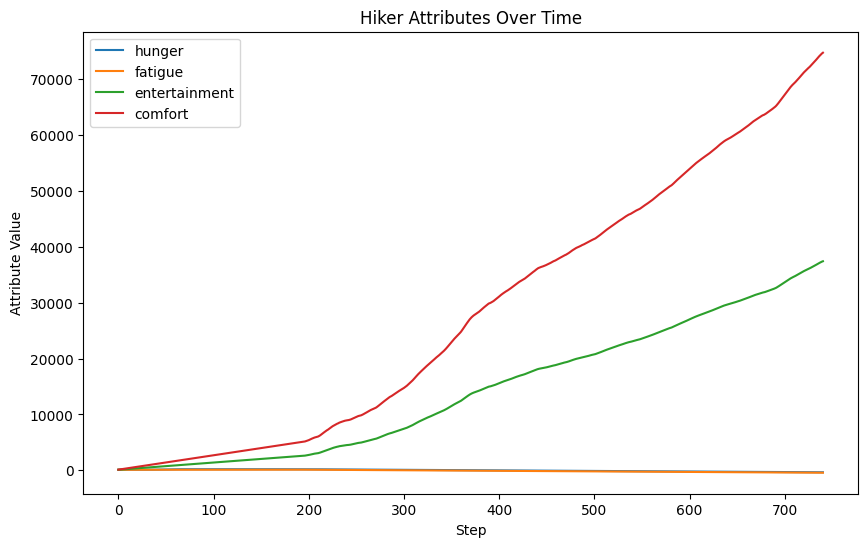

In [55]:
import matplotlib.pyplot as plt
from matplotlib import animation

# 1) Re‑use your DQN class and load weights
# (Assumes policy_net is already built & weights loaded)
policy_net = agent.policy_net
policy_net.load_weights('dqn.weights.h5')

# 2) flatten_obs unchanged
def flatten_obs(obs_dict):
    return np.concatenate([
        obs_dict['agent'].flatten(),
        obs_dict['attributes'].flatten(),
        obs_dict['trail_score'].flatten(),
        obs_dict['weather_score'].flatten(),
        obs_dict['time'].flatten()
    ])

# 3) New run_episode that stops after num_tiles steps
def run_episode(env, policy_net):
    obs, _ = env.reset()
    state = flatten_obs(obs)
    
    positions = []
    all_attributes = {name: [] for name in env.attribute_names}
    total_reward = 0.0

    # We know you can only ever take at most num_tiles moves:
    for step in range(env.num_tiles):
        # pick action
        q_vals = policy_net(tf.convert_to_tensor([state], dtype=tf.float32))[0]
        action = int(tf.argmax(q_vals))

        # attempt a step; if it errors, break
        try:
            obs, reward, done, truncated, _ = env.step(action)
        except IndexError:
            # stepped off the end—stop gracefully
            break

        state = flatten_obs(obs)
        total_reward += reward

        # record for plotting
        positions.append(int(obs['agent'][0]))
        for name in env.attribute_names:
            all_attributes[name].append(env.attributes[name])

        if done:
            break

    return positions, all_attributes, total_reward

print(x)
env = TrailEnv(x+np.repeat(-835, len(x)), tile_coords, len(x))

positions, attrs, total_reward = run_episode(env, policy_net)
print(f"Episode ended in {len(positions)} steps. Total reward = {total_reward:.2f}")

# 5) Plot / animate exactly as before
fig, ax = plt.subplots(figsize=(8,2))
ax.set_xlim(0, env.size)
ax.set_ylim(0,1)
point, = ax.plot([], [], 'ro', ms=8)
ax.set_yticks([])

def init():
    point.set_data([], [])
    return (point,)

def animate(i):
    point.set_data(positions[i], 0.5)
    return (point,)

ani = animation.FuncAnimation(
    fig, animate, frames=len(positions), init_func=init,
    interval=200, blit=True
)
plt.close(fig)

plt.figure(figsize=(10,6))
for name, series in attrs.items():
    plt.plot(series, label=name)
plt.title("Hiker Attributes Over Time")
plt.xlabel("Step")
plt.ylabel("Attribute Value")
plt.legend()
plt.show()


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# --- (Re)define your data here if needed) ---
# tile_coords  = np.random.rand(2000,2)*100  # or your actual coords
# positions     = [0,1,2,3,...]              # your computed path

# Extract path coords
path = np.array(tile_coords)[positions]
xs, ys = path[:, 0], path[:, 1]

# Set up the plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.array(tile_coords)[:, 0], np.array(tile_coords)[:, 1],
        '--', color='gray', alpha=0.3, label='Full Trail')
point, = ax.plot([], [], 'ro', markersize=8, label='Agent')
step_text = ax.text(0.02, 0.95, '', transform=ax.transAxes,
                    fontsize=12, va='top')
ax.set_title("Agent Moving Along the Trail")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.legend()
ax.set_aspect('equal')

def init():
    point.set_data([], [])
    step_text.set_text('')
    return point, step_text

def animate(i):
    point.set_data(xs[i], ys[i])
    step_text.set_text(f"Segment: {i}")
    return point, step_text

ani = animation.FuncAnimation(
    fig, animate,
    frames=len(positions),
    init_func=init,
    interval=200,
    blit=True,
    repeat=False
)

plt.close(fig)
HTML(ani.to_jshtml())


NameError: name 'positions' is not defined